# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

Files already downloaded and verified
Files already downloaded and verified


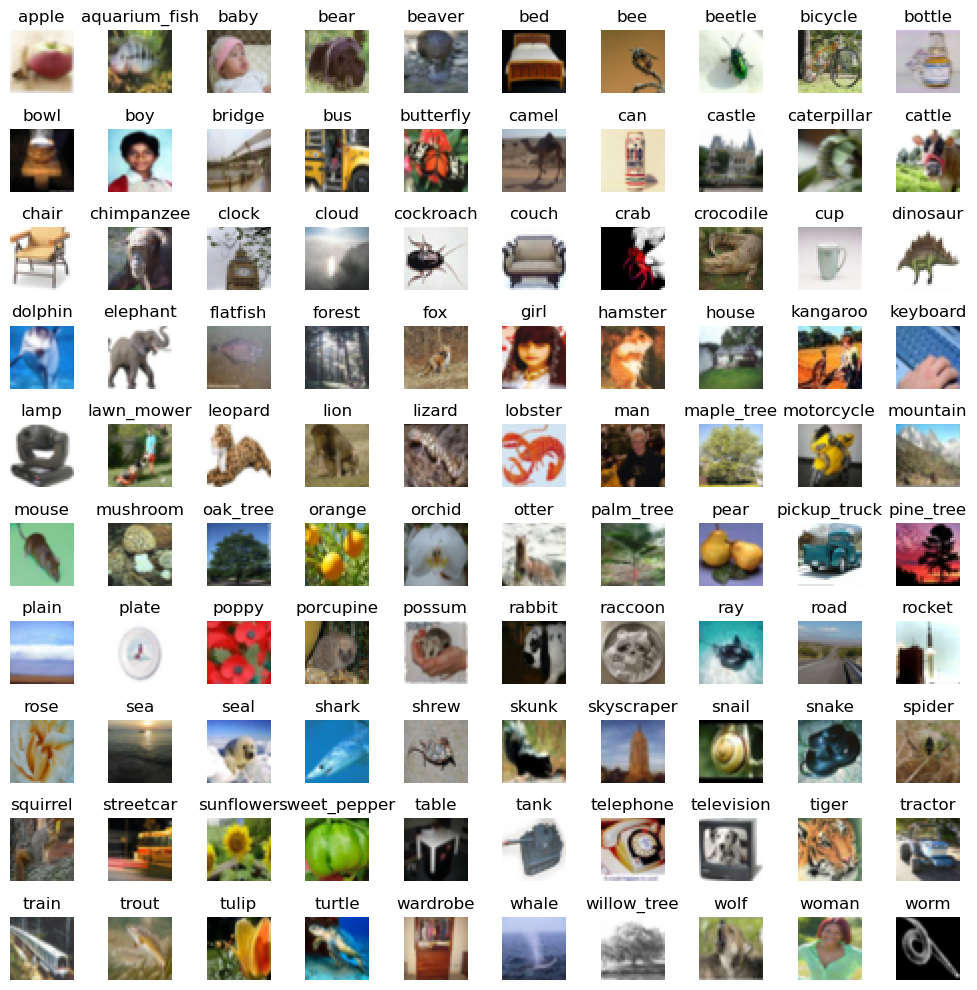

In [32]:
# Create a 10x10 subplot with random iamges and class mappings to observe our dataset
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

# Define the fine label names to get descriptive plots
fine_label_names = trainset.classes

# Predefine label positions (label -> (row, col))
label_to_position = {label: (label // 10, label % 10) for label in range(100)}

placed_labels = set()

for idx in range(len(trainset)):
    img, label = trainset[idx]
    if label in label_to_position and label not in placed_labels:
        row, col = label_to_position[label]
        
        # Normalize and transpose the image for display
        img = img / 2 + 0.5
        img = img.numpy().transpose(1, 2, 0)
        
        axs[row, col].imshow(img)
        axs[row, col].set_title(fine_label_names[label])
        axs[row, col].axis('off')
        
        placed_labels.add(label)

plt.tight_layout()
plt.savefig('fixed_positions_grid.png', dpi=300, bbox_inches='tight')
plt.show()